In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import seaborn as sns

from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

data_2020 = pd.read_csv('../../data/2020_Notebook02_train_output.csv')

try:
    data_2020.drop('Unnamed: 0',axis=1,inplace=True)
except:
    pass

#We built an extra feature that is not included in notebook2 output. If i have Price per total square meter.
#To build Price per constructed meter I'll have to pivot values.
data_2020['Precio_m2_constr'] = (data_2020['Precio_m2_total'] * data_2020['Area_total'])/data_2020['Area_constr']

#We restricted data only for Lima and Callao.

filter_1 = (data_2020['Ciudad'].isin(['Lima','Callao','Cañete']))
filter_2 = (data_2020['latitud']!= 0)

data_2020.where(filter_1 & filter_2 , inplace=True)

#Import the Lima Shape File per districts.

peru_districts = geopandas.read_file('../../data/GeoShape_Distritos/DISTRITOS.shp')
lima_districts = peru_districts[peru_districts['DEPARTAMEN'] == 'LIMA']

#Aggregate Polygons geometries to get Lima Department Polygon:
lima_department = geopandas.GeoSeries([lima_districts[lima_districts['DEPARTAMEN']=='LIMA'].unary_union])

#Aggregate Polygons geometries to get Lima District Polygon:
lima_province = geopandas.GeoSeries([lima_districts[lima_districts['PROVINCIA']=='LIMA'].unary_union])

#We only awant districts inside Lima.
lima_filter = (peru_districts['DEPARTAMEN'] == 'LIMA') 

lima_districts = peru_districts[lima_filter]

#We need shapely object. We can transform lats and longs into a shapely.Point object

gdf = geopandas.GeoDataFrame(
    data_2020, geometry=geopandas.points_from_xy(data_2020.longitud, data_2020.latitud))

gdf = gdf[gdf['geometry'].apply(lambda x: x.within(lima_department.values[0]))]

#Temporal drop: Since there are many outliers we'll drop some values.
# -------------------------------------------------------------------
gdf = gdf[gdf['Precio_m2_total'] < 9000]

gdf = gdf[gdf['Precio_m2_constr']<11000]

In [2]:
#SET OFF WARNINGS
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
#Inside Lima Filter

gdf = gdf[gdf['geometry'].apply(lambda x: x.within(lima_province.values[0]))]

In [4]:
gdf = gdf.set_crs("EPSG:4326")
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
gdf = gdf.reset_index(drop=True).reset_index().rename(columns={'index':'ID'})
gdf

,ID,latitud,longitud,Barrio,Ciudad,Area_total,Area_constr,MONEDA,Area_constr_cat,NroBanios,...,areas_proporcion,geohash_grado5,geohash_grado6,geohash_grado7,geohash_grado8,geohash_grado9,diff_total_mean_district,Precio_m2_total,Precio_m2_constr,geometry
0,0,-12.119831,-77.016015,Miraflores,Lima,398.0,352.0,S/,11.0,4.0,...,1.130682,6mc5p,6mc5p3,6mc5p3w,6mc5p3ws,6mc5p3wsu,258.315217,6550.251256,7406.250000,POINT (-77.01601 -12.11983)
1,1,-12.080734,-76.914384,La Molina,Lima,750.0,550.0,S/,17.0,4.0,...,1.363636,6mc73,6mc73b,6mc73bb,6mc73bb8,6mc73bb8s,205.376812,6030.000000,8222.727273,POINT (-76.91438 -12.08073)
2,2,-12.089309,-76.935051,La Molina,Lima,1080.0,600.0,USD,18.0,4.0,...,1.800000,6mc71,6mc71r,6mc71r1,6mc71r1w,6mc71r1we,-27.605863,4212.962963,7583.333333,POINT (-76.93505 -12.08931)
3,3,-12.093773,-77.067285,Magdalena,Lima,816.0,815.0,S/,19.0,5.0,...,1.001227,6mc5n,6mc5nq,6mc5nq3,6mc5nq3k,6mc5nq3kd,-398.451049,5147.058824,5153.374233,POINT (-77.06728 -12.09377)
4,4,-12.214983,-77.009185,Chorrillos,Lima,1200.0,570.0,USD,18.0,4.0,...,2.105263,6mc4x,6mc4x8,6mc4x87,6mc4x87d,6mc4x87de,-30.451049,3500.000000,7368.421053,POINT (-77.00918 -12.21498)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,3472,-12.066539,-76.911124,La Molina,Lima,1300.0,500.0,S/,17.0,4.0,...,2.600000,6mc73,6mc73g,6mc73g7,6mc73g75,6mc73g752,-114.605863,3320.000000,8632.000000,POINT (-76.91112 -12.06654)
3473,3473,-12.073589,-76.886133,La Molina,Lima,855.0,397.0,S/,13.0,4.0,...,2.153652,6mc76,6mc766,6mc766j,6mc766j4,6mc766j4p,-493.254902,2776.608187,5979.848866,POINT (-76.88613 -12.07359)
3474,3474,-12.354781,-76.809923,Punta Negra,Lima,437.0,340.0,S/,11.0,4.0,...,1.285294,6mc3s,6mc3sn,6mc3snu,6mc3snus,6mc3snusp,-303.451049,5242.105263,6737.647059,POINT (-76.80992 -12.35478)
3475,3475,-12.108089,-76.960098,Santiago de Surco,Lima,300.0,563.0,USD,18.0,4.0,...,0.532860,6mc70,6mc70e,6mc70ez,6mc70ez3,6mc70ez37,691.766534,7583.333333,4040.852575,POINT (-76.96010 -12.10809)


### Map Matching.

We will extract point of interests from OSMnx and transpolate those features to our housing dataset. First we will restrict our total area of interest and then we will unify that dataframe with our origins. We are choosing these categories: 'school','restaurant','parking','marketplace','bank','college','university','bus_station','police','clinic'

In [6]:
gdf_ch = gdf.unary_union.convex_hull

In [7]:
#amenities = ox.geometries_from_polygon(gdf_ch, tags={"amenity":['school','restaurant','parking','marketplace','bank','college','university','bus_station','police','clinic']})[["amenity","name","geometry"]]
#Inside Lima Filter
#amenities = amenities[amenities['geometry'].apply(lambda x: x.within(lima_province.values[0]))]
#amenities.to_csv('amenities.csv')
#Load our Amenities Database
import geopandas
from shapely import wkt
import pandas as pd
import time
amenities = pd.read_csv('amenities.csv')
geometry = amenities['geometry'].map(wkt.loads)
amenities.drop('geometry', axis=1, inplace=True)
amenities = geopandas.GeoDataFrame(amenities, crs='epsg:4326', geometry = geometry)


<AxesSubplot:>

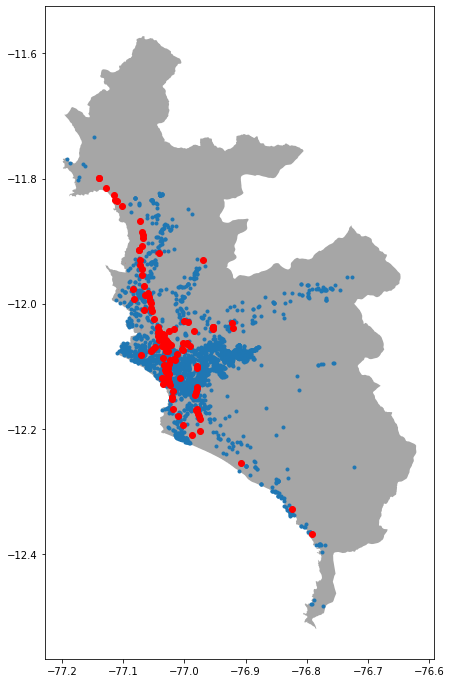

In [8]:
fig, ax = plt.subplots(1, figsize=(12,12))
lima_province.plot(ax=ax,color='grey', alpha=0.70)
gdf.plot(ax=ax, marker=".")
amenities[amenities.amenity == 'bus_station'].plot(ax=ax, color='r')

**To make a Feature Engineer with this we have to decide what is nearby for housing decision, it could be 500 meters or even 1km for this.**


In [9]:
gdf['buffer_500m'] = gdf.buffer(0.01)

In [10]:
gdf.iloc[0,:]['buffer_500m'].area

0.0003136548490545613

<AxesSubplot:>

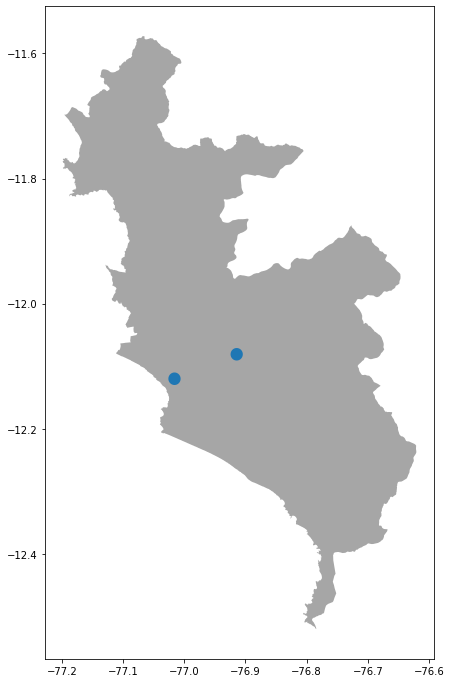

In [11]:
#see one buffer to be sure makes sense.
buffer = gdf.iloc[0:2,:]['buffer_500m']
fig, ax = plt.subplots(1, figsize=(12,12))
lima_province.plot(ax=ax,color='grey', alpha=0.70)
buffer.plot(ax=ax)

#### Creating All Point Of interest Features:

**CAVEAT:** 0.005 is an Hyperparameter that needs to be validated.

In [12]:
dict_poi = {}
gdf['buffer_500m'] = gdf.buffer(0.005)
for amenity in amenities['amenity'].unique():
    amenity_df = amenities[amenities['amenity'] == amenity]
    joined = geopandas.sjoin(amenity_df, gdf.set_geometry('buffer_500m')[['ID','buffer_500m']], op='within')
    poi_count = joined.reset_index().groupby("ID")["osmid"].count().to_frame('{}_poi_count'.format(amenity))
    dict_poi[amenity] = poi_count

In [13]:
#Merge with Origin Data (GDF)
#GDF size = 3477,25 - dict-bank 2776,1
for amenity_name, poi_count in dict_poi.items():
    
    temp_df = dict_poi[amenity_name].reset_index()
    gdf = gdf.merge(temp_df, on=['ID'],how='left').fillna(0.0)

In [14]:
gdf.columns

Index(['ID', 'latitud', 'longitud', 'Barrio', 'Ciudad', 'Area_total',
       'Area_constr', 'MONEDA', 'Area_constr_cat', 'NroBanios', 'Dormitorios',
       'Antiguedad', 'Cocheras', 'areas_diff', 'areas_proporcion',
       'geohash_grado5', 'geohash_grado6', 'geohash_grado7', 'geohash_grado8',
       'geohash_grado9', 'diff_total_mean_district', 'Precio_m2_total',
       'Precio_m2_constr', 'geometry', 'buffer_500m', 'bank_poi_count',
       'parking_poi_count', 'clinic_poi_count', 'restaurant_poi_count',
       'school_poi_count', 'bus_station_poi_count', 'college_poi_count',
       'university_poi_count', 'marketplace_poi_count', 'police_poi_count'],
      dtype='object')

#### Distance Bands and Distance Buffers:

We will use Distance Bands weight objects, considering other houses as "neighbors" if they are within the distance threshold. In other words, we will be considering the median of some feature around the spatial distance that we will define.

In [ ]:
import libpysal.weights as weights

d500_w = weights.DistanceBand.from_dataframe(gdf, threshold=500, silence_warnings=True)
d500_w.transform = 'r'

local_average_bedrooms = weights.lag_spatial(d500_w, gdf[['Dormitorios']].values)

plt.scatter(gdf[['Dormitorios']].values, local_average_bedrooms)

In [27]:
gdf['local_average_bedrooms'] = local_average_bedrooms

Total time executed: 118.33638763427734


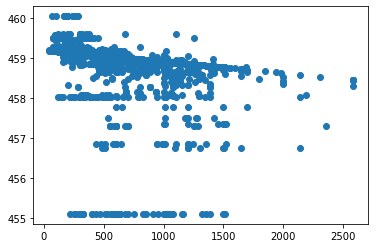

In [35]:
#Instead of just see bedrooms let's see Total Areas. 
import time
start = time.time()
area_500_w = weights.DistanceBand.from_dataframe(gdf, threshold=500, silence_warnings=True)
area_500_w.transform = 'r'

local_average_total_area = weights.lag_spatial(area_500_w, gdf[['Area_total']].values)

plt.scatter(gdf[['Area_total']].values, local_average_total_area)
end = time.time()
print("Total time executed: {}".format(end-start))

In [39]:
gdf['local_average_total_area'] = local_average_total_area

In [42]:
gdf

,ID,latitud,longitud,Barrio,Ciudad,Area_total,Area_constr,MONEDA,Area_constr_cat,NroBanios,...,clinic_poi_count,restaurant_poi_count,school_poi_count,bus_station_poi_count,college_poi_count,university_poi_count,marketplace_poi_count,police_poi_count,local_average_bedrooms,local_average_total_area
0,0,-12.119831,-77.016015,Miraflores,Lima,398.0,352.0,S/,11.0,4.0,...,4.0,9.0,5.0,0.0,0.0,0.0,1.0,1.0,4.438147,459.091197
1,1,-12.080734,-76.914384,La Molina,Lima,750.0,550.0,S/,17.0,4.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,4.438147,458.989931
2,2,-12.089309,-76.935051,La Molina,Lima,1080.0,600.0,USD,18.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.438147,458.894994
3,3,-12.093773,-77.067285,Magdalena,Lima,816.0,815.0,S/,19.0,5.0,...,3.0,22.0,15.0,0.0,2.0,1.0,0.0,2.0,4.437284,458.970944
4,4,-12.214983,-77.009185,Chorrillos,Lima,1200.0,570.0,USD,18.0,4.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.437302,457.512828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3472,3472,-12.066539,-76.911124,La Molina,Lima,1300.0,500.0,S/,17.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.439285,456.767234
3473,3473,-12.073589,-76.886133,La Molina,Lima,855.0,397.0,S/,13.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.438147,458.959724
3474,3474,-12.354781,-76.809923,Punta Negra,Lima,437.0,340.0,S/,11.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.437986,459.068201
3475,3475,-12.108089,-76.960098,Santiago de Surco,Lima,300.0,563.0,USD,18.0,4.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.438147,459.119390


In [43]:
gdf.to_csv('train_geodataframe.csv', index=False)